In [1]:
import xarray as xr
import numpy as np
#import pandas as pd
import os
import glob
import copy as cp
import random
import pyproj as proj
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import normalize
from sklearn.model_selection import KFold
from sklearn.metrics.pairwise import cosine_similarity 
from sklearn import cluster
import wpca
import pandas as pd
import pickle 
from matplotlib.cm import get_cmap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import cartopy.crs as ccrs
import cartopy as cr
import matplotlib.cm as cm
from scipy.stats.stats import pearsonr   
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from datetime import datetime

In [2]:
SUB_SETS = {'all':{'Subset_name':'/storage/nplanat/Glorys12_OP_journalier/NEW_RUN/Sub_samp_y_1993_-_2014_delta_1_100000_start_lon_0.nc',\
                  'init_year':1993,\
                  'final_year':2014,\
                   'delta_year':1,\
                  'N_particles':100000,\
                  'Subset_path':'/storage/nplanat/Glorys12_OP_journalier/NEW_RUN/'},\
           'weird_path_only':{'Subset_name':'/storage/nplanat/Glorys12_OP_journalier/WEIRD/Sub_samp_y_1996_-_1997_-delta_1_40000_start_lon_0.nc',\
                  'init_year':1996,\
                  'final_year':1997,\
                   'delta_year':1,\
                  'N_particles':40000,\
                  'Subset_path':'/storage/nplanat/Glorys12_OP_journalier/WEIRD/'},\
           'without_weird_path':{'Subset_name':None,\
                  'init_year':1993,\
                  'final_year':2014,\
                   'delta_year':1,\
                  'N_particles':100000,\
                  'Subset_path':'/storage/nplanat/Glorys12_OP_journalier/NO_WEIRD/'},\
           'all_short':{'Subset_name':'/storage/nplanat/Glorys12_OP_journalier/SHORT/Sub_samp_y_1993_-_2014_delta_1_100000_start_lon_0.nc',\
                  'init_year':1993,\
                  'final_year':2014,\
                   'delta_year':1,\
                  'N_particles':100000,\
                  'Subset_path':'/storage/nplanat/Glorys12_OP_journalier/SHORT/'}}

In [3]:
sel_subset = 'all_short'
load_previous_run = True
init_year = SUB_SETS[sel_subset]['init_year']
final_year = SUB_SETS[sel_subset]['final_year']
delta_year = SUB_SETS[sel_subset]['delta_year']
Subset_name = SUB_SETS[sel_subset]['Subset_name']
N_particles = SUB_SETS[sel_subset]['N_particles']
Subset_path = SUB_SETS[sel_subset]['Subset_path']

files = sorted(glob.glob('/storage/nplanat/Glorys12_OP_journalier/ADV_new_*'))
files_m = sorted(glob.glob('/storage/nplanat/Glorys12_OP_journalier/ADV_m_200_*'))
files_s = sorted(glob.glob('/storage/nplanat/Glorys12_OP_journalier/ADV_s_200_*'))
length_days = 450
path_save_prediction = Subset_path 


perctest = 0.1 
perctrain = 0.8
trans = True

#PCA 
n_components = 0.9999999

# Clustering
init = 'k-means++'
nmb_initialisations = 20  # number of initiatilisaton for the k-means++ 
max_iter = 500
tol = 5e-4
algorithm = 'full'
verbose = 0 
sample_weight = None
n_split = 20  # number of iterations for convergence
n_clusters = 20 #number of clusters

In [4]:
#load PCA : 
with open(Subset_path + 'pca.pkl', 'rb') as pickle_file:
    pca = pickle.load(pickle_file)
#load clustering : 
Traj_centroids = np.load(Subset_path+'Traj_centroids.npy', allow_pickle = True)
# load previous runs :
Labels_valid = np.load(path_save_prediction+'Labels_valid.npy')
Labels_test = np.load(path_save_prediction+'Labels_test.npy')
lats_test = np.load(path_save_prediction+'lats_test.npy')
lons_test = np.load(path_save_prediction+'lons_test.npy')
lats_train = np.load(path_save_prediction+'lats_train.npy')
lons_train = np.load(path_save_prediction+'lons_train.npy')
lats_valid = np.load(path_save_prediction+'lats_valid.npy')
lons_valid = np.load(path_save_prediction+'lons_valid.npy')

# Vizualization

In [5]:
def make_histo_arctic(labs, lons, lats, n_clusters):
    ncs = np.arange(n_clusters)
    Liste_hist  = []
    for nc in ncs:
        print(nc)

        cf = 'k'

        lons_pdf = [] ; lats_pdf = [] ; count=0
        for n in range(len(labs)):
            if labs[n]==nc :
                lons_pdf.extend(lons[n,:][~np.isnan(lons[n,:])]) ; lats_pdf.extend(lats[n,:][~np.isnan(lats[n,:])])
                count += 1

        # Initalize the histogram
        lon1 = 0 ; lon2 = 360 ; lat1 = 65 ; lat2 = 90
        x = np.arange(lon1,lon2,1./12.)
        y = np.arange(lat1,lat2,1./12.)

        # Calculate the histogram
        hist, xe, ye = np.histogram2d(lons_pdf, lats_pdf, bins=(x,y))
        hist[hist==0] = np.nan
        Liste_hist.append(hist.T)
    return Liste_hist

In [6]:
def plot_density_arctic(labs, lons, lats, n_clusters, vmax):
    lims = [-200, -90, 65, 90]
    ncs = np.arange(n_clusters)
    Liste_hist  = []
    f = plt.figure(figsize = (15, 8))   

    for nc in ncs:
        print(nc)

        cf = 'k'

        lons_pdf = [] ; lats_pdf = [] ; count=0
        for n in range(len(labs)):
            if labs[n]==nc :
                lons_pdf.extend(lons[n,:][~np.isnan(lons[n,:])]) ; lats_pdf.extend(lats[n,:][~np.isnan(lats[n,:])])
                count += 1

        # Initalize the histogram
        lon1 = 0 ; lon2 = 360 ; lat1 = 65 ; lat2 = 90
        x = np.arange(lon1,lon2,1./12.)
        y = np.arange(lat1,lat2,1./12.)

        # Calculate the histogram
        hist, xe, ye = np.histogram2d(lons_pdf, lats_pdf, bins=(x,y))
        hist[hist==0] = np.nan

        # plot
        ax = f.add_subplot(np.max(labs)//6+1,6,nc+1, projection = ccrs.NorthPolarStereo())
        ax.coastlines(color='silver')
        ax.gridlines(zorder=-1)
        ax.set_extent(lims,  crs=ccrs.PlateCarree())
        ax.add_feature(cr.feature.LAND, linewidth=0.5, edgecolor='white')

        im = ax.pcolor(x, y, hist.T, norm=colors.LogNorm(vmin=1.0,vmax=vmax), transform = ccrs.PlateCarree(), cmap=get_cmap('hot_r'))
        ##im = ax.pcolor(x, y, hist.T, norm=colors.LogNorm(vmin=2.0,vmax=np.nanpercentile(hist,99)), transform = ccrs.PlateCarree(), cmap=get_cmap('hot_r'))
        Liste_hist.append(hist.T)
        ax.text(0.03, 0.05, '#'+str(nc), transform=ax.transAxes, fontsize=16)
        ax.text(0.8, 0.87, str(count), transform=ax.transAxes, fontsize=16)
        #plt.contour(lonb, latb, bathy, [350], colors='dimgrey', transform = ccrs.PlateCarree(), zorder=2)

        if nc==0:
            cbaxes = inset_axes(ax, width="50%", height="5%", loc=3) 
            cbar = plt.colorbar(im, cax=cbaxes, ticks=[0.,10,50], orientation='horizontal')
    return Liste_hist, f

## Show classif on validation test

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


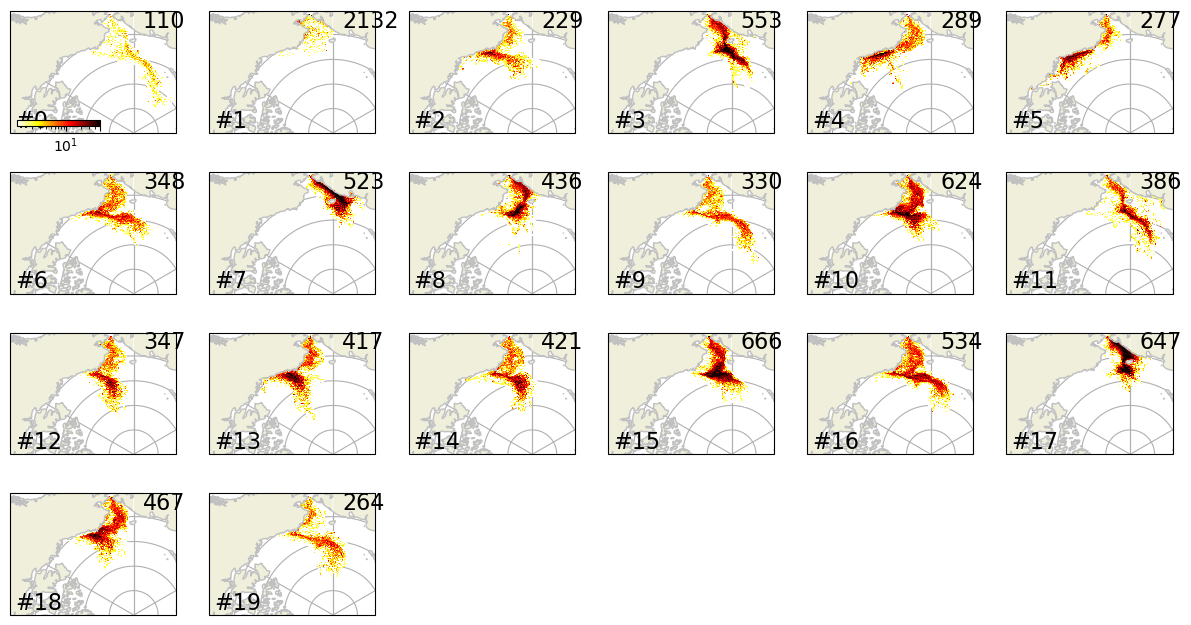

In [7]:
Hist_valid, f = plot_density_arctic(Labels_valid, lons_valid, lats_valid, n_clusters, vmax = 50)
#f.savefig('../Figures_Clustering/Figures/ALL.png')

## Groupes

In [32]:
def running_mean(t, x, N) :
    rm = np.convolve(x, np.ones((N,))/N, mode='valid')
    times = t[int(N/2):len(rm)+int(N/2)]
    return times, rm

In [33]:
L1 = [4,5]#ACC
L2 = [0,3,19,6,9,11,16]#Contourne BC
L3 = [7,17]#eurasie
L4 = [2,18,10,12,13,14,]# Entre CB
L5 = [1,8] # Chukchi shelf
L6 = [15]#NWRidge
Groupes = [L1,L2,L3,L4,L5,L6]
Names = ['ACC', 'Contourne BC', 'Eurasie', 'Entre CB', 'Chukchi shelf', 'NW Ridge']

La = [2,10,14]
Lb = [18,13,12]

Groupes2 = [La, Lb]
Names2 = ['NW', 'Direct']

In [34]:
Dates_all_s = []; Perc_labels_all_s = [];
for yr in range(1993,2014):
    try:
        print('Year', yr)
        labs_yr = np.load(path_save_prediction+'s_labels_data_%i'%yr + '.npy', allow_pickle = True)
        time_yr = np.load('/storage/nplanat/Glorys12_OP_journalier/lats_lons/s_times_%i'%yr+'.npy', allow_pickle = True)
        Date_data = np.unique(time_yr)
        Dates_all_s.extend(Date_data)
        Perc_labels = np.zeros((len(Date_data), n_clusters))
        for i in range(len(Date_data)):
            d0 = np.where(Date_data[i] ==time_yr)[0]
            for di in d0:
                Perc_labels[i,labs_yr[di]] +=1
            Perc_labels[i,:] =100*Perc_labels[i,:]/len(d0)
        Perc_labels_all_s.extend(Perc_labels)
    except: 
        print('I miss year ', yr)
Perc_labels_all_s = np.array(Perc_labels_all_s)

Year 1993
Year 1994
Year 1995
Year 1996
Year 1997
Year 1998
Year 1999
Year 2000
Year 2001
Year 2002
Year 2003
Year 2004
Year 2005
Year 2006
Year 2007
Year 2008
Year 2009
Year 2010
Year 2011
Year 2012
Year 2013


/tmp/ipykernel_3028220/447946493.py:14: RuntimeWarning: invalid value encountered in true_divide
  Perc_labels[i,:] =100*Perc_labels[i,:]/len(d0)


In [35]:
Dates_all_m = []; Perc_labels_all_m = [];
for yr in range(1993,2014):
    print('Year', yr)
    labs_yr = np.load(path_save_prediction+'m_labels_data_%i'%yr + '.npy', allow_pickle = True)
    time_yr = np.load('/storage/nplanat/Glorys12_OP_journalier/lats_lons/m_times_%i'%yr+'.npy', allow_pickle = True)
    Date_data = np.unique(time_yr)
    Dates_all_m.extend(Date_data)
    Perc_labels = np.zeros((len(Date_data), n_clusters))
    for i in range(len(Date_data)):
        d0 = np.where(Date_data[i] ==time_yr)[0]
        for di in d0:
            Perc_labels[i,labs_yr[di]] +=1
        Perc_labels[i,:] =100*Perc_labels[i,:]/len(d0)
    Perc_labels_all_m.extend(Perc_labels)
Perc_labels_all_m = np.array(Perc_labels_all_m)

Year 1993
Year 1994
Year 1995
Year 1996
Year 1997
Year 1998
Year 1999
Year 2000
Year 2001
Year 2002
Year 2003
Year 2004
Year 2005
Year 2006
Year 2007
Year 2008
Year 2009
Year 2010
Year 2011
Year 2012
Year 2013


In [36]:
Dates_all = []; Perc_labels_all = [];
for yr in range(1993,2014):
    print('Year', yr)
    labs_yr = np.load(path_save_prediction+'labels_data_%i'%yr + '.npy', allow_pickle = True)
    time_yr = np.load('/storage/nplanat/Glorys12_OP_journalier/lats_lons/times_%i'%yr+'.npy', allow_pickle = True)
    Date_data = np.unique(time_yr)
    Dates_all.extend(Date_data)
    Perc_labels = np.zeros((len(Date_data), n_clusters))
    for i in range(len(Date_data)):
        d0 = np.where(Date_data[i] ==time_yr)[0]
        for di in d0:
            Perc_labels[i,labs_yr[di]] +=1
        Perc_labels[i,:] =100*Perc_labels[i,:]/len(d0)
    Perc_labels_all.extend(Perc_labels)
Perc_labels_all = np.array(Perc_labels_all)

Year 1993
Year 1994
Year 1995
Year 1996
Year 1997
Year 1998
Year 1999
Year 2000
Year 2001
Year 2002
Year 2003
Year 2004
Year 2005
Year 2006
Year 2007
Year 2008
Year 2009
Year 2010
Year 2011
Year 2012
Year 2013


In [37]:
Liste_h = make_histo_arctic(Labels_valid, lons_valid, lats_valid, n_clusters)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


### Show 6 groupes

groupe,  0
groupe,  1
groupe,  2
groupe,  3
groupe,  4
groupe,  5


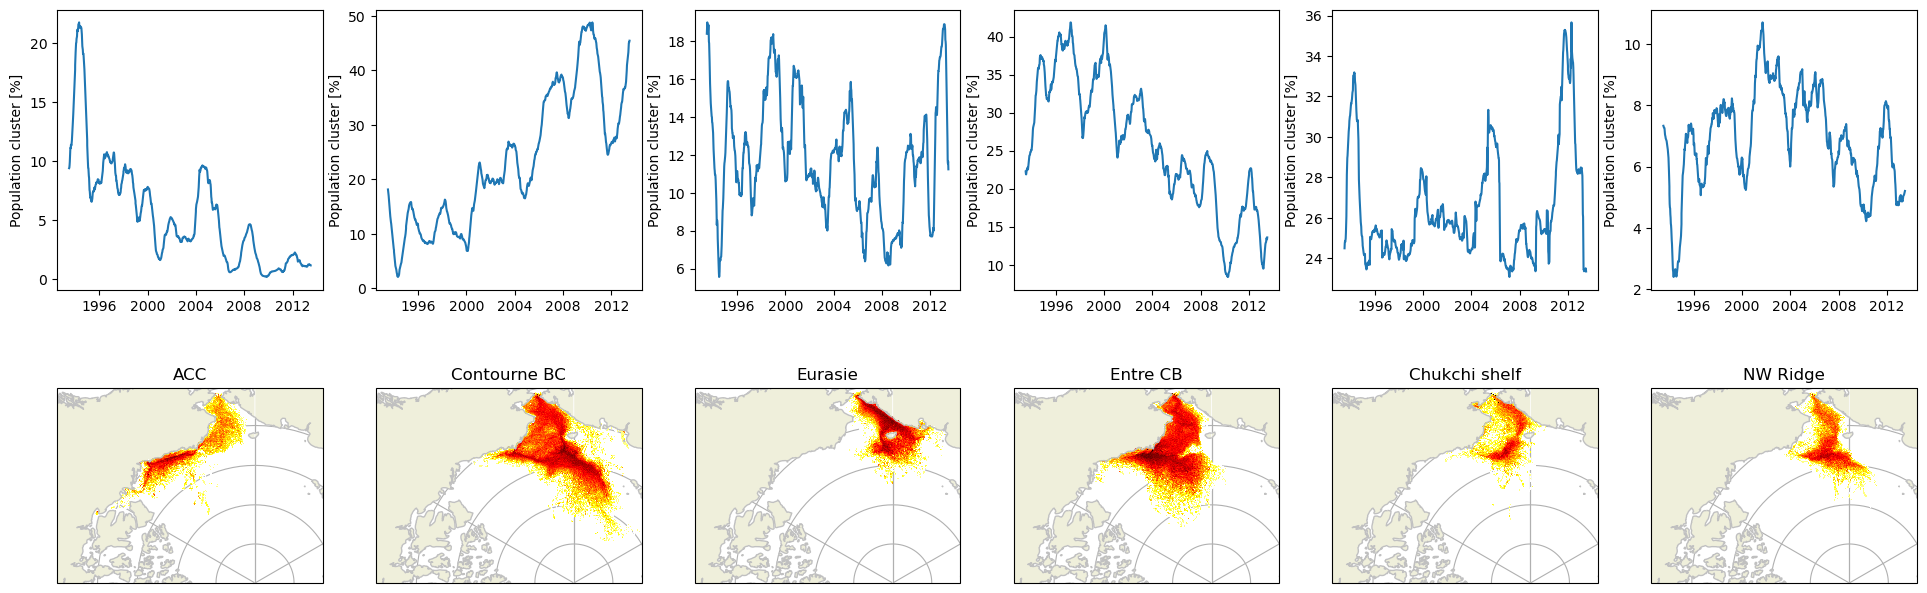

In [38]:
vmax = 300
f = plt.figure(figsize = (len(Groupes)*4, 8))
for i in range(len(Groupes)):
    print('groupe, ', i)
    ax = f.add_subplot(2,len(Groupes),i+1)
    #ax.plot(Dates_all, np.sum(Perc_labels_all[:,Groupes[i]], axis = 1))
    tm0,rm = running_mean(Dates_all, np.sum(Perc_labels_all[:,Groupes[i]], axis = 1), 53)
    ax.plot(tm0, rm)
    ax.set_ylabel('Population cluster [%]')
    ax = f.add_subplot(2,len(Groupes),len(Groupes)+i+1,projection  = ccrs.NorthPolarStereo())
    # Initalize the histogram
    lon1 = 0 ; lon2 = 360 ; lat1 = 65 ; lat2 = 90
    x = np.arange(lon1,lon2,1./12.)
    y = np.arange(lat1,lat2,1./12.)
    lims = [-200, -90, 65, 90]
    ax.coastlines(color='silver')
    ax.gridlines(zorder=-1)
    ax.set_extent(lims,  crs=ccrs.PlateCarree())
    ax.add_feature(cr.feature.LAND, linewidth=0.5, edgecolor='white')
    A = np.nansum(np.array(Liste_h)[Groupes[i],:,:], axis = 0)
    #count = np.round(np.nansum(np.array(Liste_h)[Groupes[i],:,:])/1000000, 2)
    im = ax.pcolormesh(x, y, A, norm=colors.LogNorm(vmin=1.0,vmax=vmax), transform = ccrs.PlateCarree(), cmap=get_cmap('hot_r'))
    ax.set_title(Names[i])
#f.savefig('../Figures_Clustering/Figures/'+sel_subset+'/Arctic_groups_'+str(yr)+'.png', transparent=False)
#plt.close()

### Show variation at Pt. Barrow

groupe,  0
groupe,  1


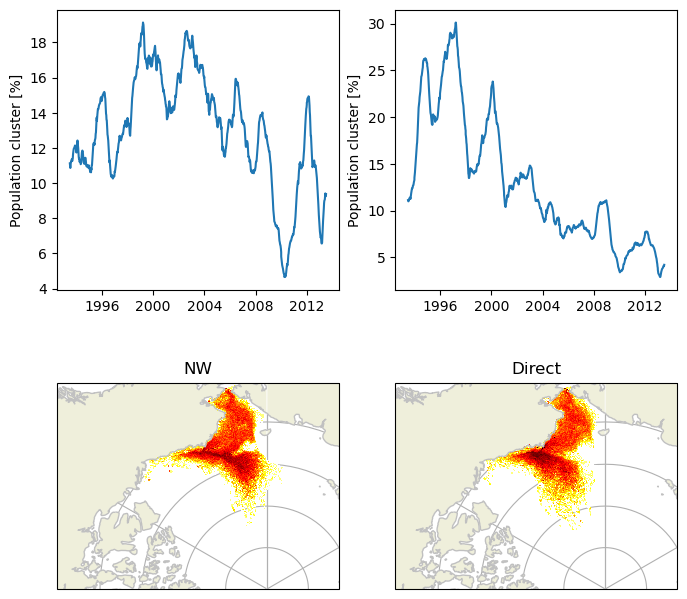

In [39]:
vmax = 200

#Liste_h = make_histo_arctic(Labels_valid, lons_valid, lats_valid, n_clusters)
f = plt.figure(figsize = (len(Groupes2)*4, 8))
for i in range(len(Groupes2)):
    print('groupe, ', i)
    ax = f.add_subplot(2,len(Groupes2),i+1)
    #ax.plot(Dates_all, np.sum(Perc_labels_all[:,Groupes[i]], axis = 1))
    tm0,rm = running_mean(Dates_all, np.sum(Perc_labels_all[:,Groupes2[i]], axis = 1), 53)
    ax.plot(tm0, rm)
    ax.set_ylabel('Population cluster [%]')
    ax = f.add_subplot(2,len(Groupes2),len(Groupes2)+i+1,projection  = ccrs.NorthPolarStereo())
    # Initalize the histogram
    lon1 = 0 ; lon2 = 360 ; lat1 = 65 ; lat2 = 90
    x = np.arange(lon1,lon2,1./12.)
    y = np.arange(lat1,lat2,1./12.)
    lims = [-200, -90, 65, 90]
    ax.coastlines(color='silver')
    ax.gridlines(zorder=-1)
    ax.set_extent(lims,  crs=ccrs.PlateCarree())
    ax.add_feature(cr.feature.LAND, linewidth=0.5, edgecolor='white')
    A = np.nansum(np.array(Liste_h)[Groupes2[i],:,:], axis = 0)
    #count = np.round(np.nansum(np.array(Liste_h)[Groupes[i],:,:])/1000000, 2)
    im = ax.pcolormesh(x, y, A, norm=colors.LogNorm(vmin=1.0,vmax=vmax), transform = ccrs.PlateCarree(), cmap=get_cmap('hot_r'))
    ax.set_title(Names2[i])
#f.savefig('../Figures_Clustering/Figures/'+sel_subset+'/Arctic_groups_'+str(yr)+'.png', transparent=False)
#plt.close()

### Show difference in transport between different runs

groupe,  0
groupe,  1
groupe,  2
groupe,  3
groupe,  4
groupe,  5


Text(0.5, 1.0, '- daily, --monthly, :seasons')

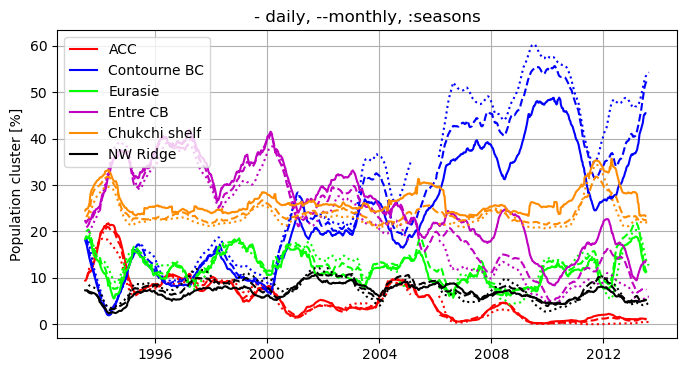

In [40]:
G = Groupes
N = Names

f = plt.figure(figsize = (8,4))
ax = f.add_subplot(1,1,1)
Colors = ['r', 'b', 'lime', 'm', 'DarkOrange', 'k']
for i in range(len(G)):
    print('groupe, ', i)
    tm0, rm = running_mean(Dates_all, np.nansum(Perc_labels_all[:,G[i]], axis = 1), 53)
    ax.plot(tm0, rm, label = N[i], ls= '-', c = Colors[i])
    tm0, rm = running_mean(Dates_all_m, np.nansum(Perc_labels_all_m[:,G[i]], axis = 1), 53)
    ax.plot(tm0, rm,  ls = '--',c = Colors[i])    
    tm0, rm = running_mean(Dates_all_s, np.nansum(Perc_labels_all_s[:,G[i]], axis = 1), 53)
    ax.plot(tm0, rm,  ls = ':', c = Colors[i])
    ax.set_ylabel('Population cluster [%]')
    
ax.grid('on')
ax.legend(loc= 'upper left')
ax.set_title('- daily, --monthly, :seasons')
#f.savefig('difference.png')

groupe,  0
groupe,  1


Text(0.5, 1.0, '- daily, --monthly, :seasons')

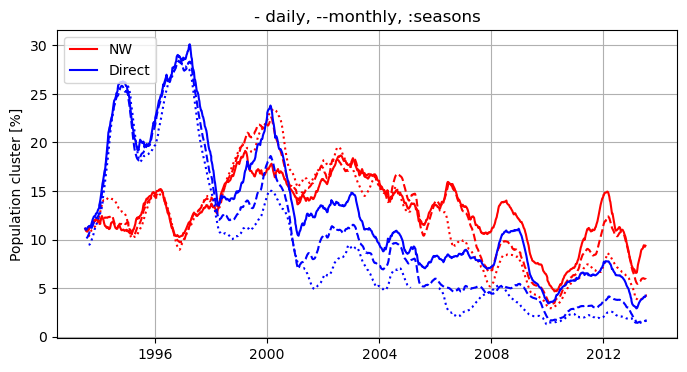

In [41]:
G = Groupes2
N = Names2

f = plt.figure(figsize = (8,4))
ax = f.add_subplot(1,1,1)
Colors = ['r', 'b', 'lime', 'm', 'DarkOrange', 'k']
for i in range(len(G)):
    print('groupe, ', i)
    tm0, rm = running_mean(Dates_all, np.nansum(Perc_labels_all[:,G[i]], axis = 1), 53)
    ax.plot(tm0, rm, label = N[i], ls= '-', c = Colors[i])
    tm0, rm = running_mean(Dates_all_m, np.nansum(Perc_labels_all_m[:,G[i]], axis = 1), 53)
    ax.plot(tm0, rm,  ls = '--',c = Colors[i])    
    tm0, rm = running_mean(Dates_all_s, np.nansum(Perc_labels_all_s[:,G[i]], axis = 1), 53)
    ax.plot(tm0, rm,  ls = ':', c = Colors[i])
    ax.set_ylabel('Population cluster [%]')
    
ax.grid('on')
ax.legend(loc= 'upper left')
ax.set_title('- daily, --monthly, :seasons')
#f.savefig('difference.png')

## Vizualise on the entire dataset - overfitting ? 

In [42]:
if False: 
    for yr in range(1993, 2014):
        labs_yr = np.load(path_save_prediction+'labels_data_%i'%yr + '.npy', allow_pickle = True)
        lats_yr = np.load('/storage/nplanat/Glorys12_OP_journalier/lats_lons/'+'lats_%i'%yr + '.npy', allow_pickle = True)
        lons_yr = np.load('/storage/nplanat/Glorys12_OP_journalier/lats_lons/'+'lons_%i'%yr +'.npy', allow_pickle = True)
        Hist_valid, f = plot_density_arctic(labs_yr, lons_yr, lats_yr, n_clusters, vmax = 100)
        f.savefig('/storage/nplanat/Work_Backuped/GitHub/Clustering_Lagragian_particles/Figures_Clustering/Figures/'+sel_subset+'/Arctic_'+str(yr)+'.png')
        plt.close()
    for yr in range(1993, 2014):
        labs_yr = np.load(path_save_prediction+'m_labels_data_%i'%yr + '.npy', allow_pickle = True)
        lats_yr = np.load('/storage/nplanat/Glorys12_OP_journalier/lats_lons/'+'m_lats_%i'%yr + '.npy', allow_pickle = True)
        lons_yr = np.load('/storage/nplanat/Glorys12_OP_journalier/lats_lons/'+'m_lons_%i'%yr +'.npy', allow_pickle = True)
        Hist_valid, f = plot_density_arctic(labs_yr, lons_yr, lats_yr, n_clusters, vmax = 100)
        f.savefig('/storage/nplanat/Work_Backuped/GitHub/Clustering_Lagragian_particles/Figures_Clustering/Figures/'+sel_subset+'/m_Arctic_'+str(yr)+'.png')
        plt.close()
    for yr in range(1993, 2014):
        labs_yr = np.load(path_save_prediction+'s_labels_data_%i'%yr + '.npy', allow_pickle = True)
        lats_yr = np.load('/storage/nplanat/Glorys12_OP_journalier/lats_lons/'+'s_lats_%i'%yr + '.npy', allow_pickle = True)
        lons_yr = np.load('/storage/nplanat/Glorys12_OP_journalier/lats_lons/'+'s_lons_%i'%yr +'.npy', allow_pickle = True)
        Hist_valid, f = plot_density_arctic(labs_yr, lons_yr, lats_yr, n_clusters, vmax = 100)
        f.savefig('/storage/nplanat/Work_Backuped/GitHub/Clustering_Lagragian_particles/Figures_Clustering/Figures/'+sel_subset+'/s_Arctic_'+str(yr)+'.png')
        plt.close()

In [43]:
if False:
    vmax = 300
    for yr in range(1993, 2014):
        print('year: ', yr)
        labs_yr = np.load(path_save_prediction+'labels_data_%i'%yr + '.npy', allow_pickle = True)
        lats_yr = np.load('/storage/nplanat/Glorys12_OP_journalier/lats_lons/'+'lats_%i'%yr + '.npy', allow_pickle = True)
        lons_yr = np.load('/storage/nplanat/Glorys12_OP_journalier/lats_lons/'+'lons_%i'%yr +'.npy', allow_pickle = True) 
        Liste_h = make_histo_arctic(labs_yr, lons_yr, lats_yr, n_clusters)
        f = plt.figure(figsize = (len(Groupes)*4, 8))
        for i in range(len(Groupes)):
            print('groupe, ', i)
            ax = f.add_subplot(2,len(Groupes),i+1)
            ax.plot(Dates_all, np.sum(Perc_labels_all[:,Groupes[i]], axis = 1))
            tm0,rm = running_mean(Dates_all, np.sum(Perc_labels_all[:,Groupes[i]], axis = 1), 53)
            ax.plot(tm0, rm)
            ax.set_ylabel('Population cluster [%]')
            if i == 0:
                ax.text(0.71, 0.87, str(yr), transform=ax.transAxes, fontsize=16)
            ax = f.add_subplot(2,len(Groupes),len(Groupes)+i+1,projection  = ccrs.NorthPolarStereo())
            # Initalize the histogram
            lon1 = 0 ; lon2 = 360 ; lat1 = 65 ; lat2 = 90
            x = np.arange(lon1,lon2,1./12.)
            y = np.arange(lat1,lat2,1./12.)
            lims = [-200, -90, 65, 90]
            ax.coastlines(color='silver')
            ax.gridlines(zorder=-1)
            ax.set_extent(lims,  crs=ccrs.PlateCarree())
            ax.add_feature(cr.feature.LAND, linewidth=0.5, edgecolor='white')
            A = np.nansum(np.array(Liste_h)[Groupes[i],:,:], axis = 0)
            #count = np.round(np.nansum(np.array(Liste_h)[Groupes[i],:,:])/1000000, 2)
            im = ax.pcolormesh(x, y, A, norm=colors.LogNorm(vmin=1.0,vmax=vmax), transform = ccrs.PlateCarree(), cmap=get_cmap('hot_r'))
            ax.set_title(Names[i])
        f.savefig('../Figures_Clustering/Figures/'+sel_subset+'/Arctic_groups_'+str(yr)+'.png', transparent=False)
    plt.close()